In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

# StringIO behaves like a file object 
from io import StringIO 

print(tf.__version__)

2.2.0


In [87]:
c = ''
with open("test_number_9_10_apenas.txt", "r") as fd:
    c = StringIO(fd.read())
    
d = c.read()
c = StringIO(d) 
d = np.loadtxt(c) 
feature_names = ['9','10','final_lamb']
# feature_names = ['second_lamb','second_phi','second_deriv','third_lamb','third_phi','third_deriv','fourth_lamb','fourth_phi','fourth_deriv','final_lamb']
# 
# feature_names = ['a','b','d','r','inicital_lamb','second_lamb','third_lamb','fourth_lamb','final_lamb']


knapsack = {"data":d, "feature_names": feature_names}
dataset = pd.DataFrame(knapsack['data'], columns = knapsack['feature_names'])

In [88]:
dataset

,9,10,final_lamb
0,11516.765565,58810.401820,8.781304
1,10788.134706,57739.848840,8.791802
2,9360.533744,57098.647305,8.823496
3,12169.717208,60661.391026,8.775503
4,8595.188800,56701.116330,8.839068
...,...,...,...
9995,13763.245923,60728.626409,8.734889
9996,7966.956837,55332.689024,8.845568
9997,3240.113655,51439.090662,8.938663
9998,3974.820355,52747.467883,8.925512


In [89]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

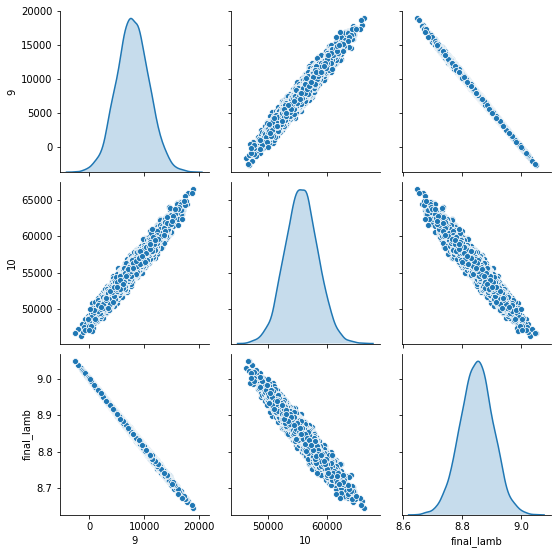

In [90]:
sns.pairplot(train_dataset[["9", "10", "final_lamb"]], diag_kind="kde")


In [91]:
train_stats = train_dataset.describe()
train_stats.pop("final_lamb")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
9,8000.0,7949.822974,2955.000578,-2584.775141,5972.294432,7897.630625,9911.350570,18980.099274
10,8000.0,55730.697295,2785.167514,46340.859919,53872.836339,55700.936726,57568.697643,66409.465694


In [92]:
train_labels = train_dataset.pop('final_lamb')
test_labels = test_dataset.pop('final_lamb')

In [93]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [94]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [95]:
model = build_model()

In [96]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [97]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.28658596],
       [-0.06329826],
       [-0.24090767],
       [-0.05939473],
       [-0.29299095],
       [-0.2017751 ],
       [-0.14770103],
       [-0.00744887],
       [-0.13091289],
       [-0.19032225]], dtype=float32)

In [98]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 5000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [99]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
4995,0.000107,0.010200,0.000107,0.000110,0.010358,0.000110,4995
4996,0.000106,0.010154,0.000106,0.000140,0.011708,0.000140,4996
4997,0.000106,0.010122,0.000106,0.000084,0.009078,0.000084,4997
4998,0.000106,0.010037,0.000106,0.000098,0.009820,0.000098,4998
4999,0.000106,0.010100,0.000106,0.000077,0.008594,0.000077,4999


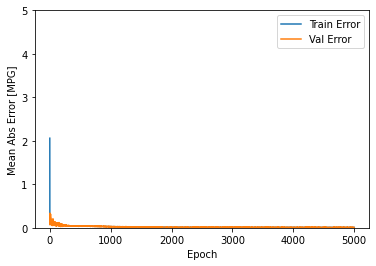

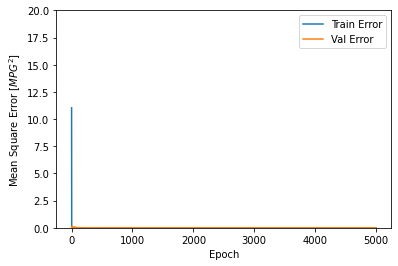

In [100]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [101]:
# model = build_model()

# # O paramêtro patience é o quantidade de epochs para checar as melhoras
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
#                     validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# plot_history(history)

In [102]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

63/63 - 0s - loss: 7.6078e-05 - mae: 0.0085 - mse: 7.6078e-05
Testing set Mean Abs Error:  0.01 MPG


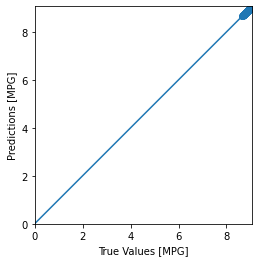

In [103]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

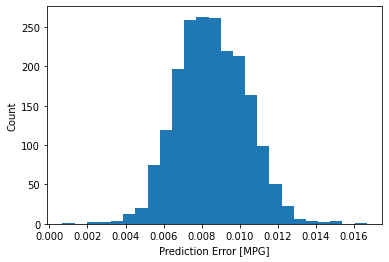

In [104]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [105]:
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
example_result

array([[8.788845 ],
       [8.841265 ],
       [8.86927  ],
       [8.917841 ],
       [8.944074 ],
       [8.8399935],
       [9.007382 ],
       [8.81139  ],
       [8.799964 ],
       [8.912501 ]], dtype=float32)

In [106]:
test_labels[:10]

0     8.781304
13    8.832606
21    8.861154
25    8.906618
26    8.932027
28    8.834582
35    8.995795
41    8.806436
43    8.795230
52    8.904232
Name: final_lamb, dtype: float64

In [53]:
example_batch

,9,10
0,1.207087,1.105752
13,0.353434,0.778429
21,-0.264530,-0.539050
25,-1.054407,-1.126270
26,-1.468424,-1.116856
28,0.255864,0.024717
35,-2.616511,-2.902435
41,0.833119,0.921005
43,0.985985,0.778565
52,-0.960144,-1.006759
